# Survey Study: a tutorial

This Jupyter notebook aims to help razorback users to compute impedance estimates from the data set shown in the paper in different ways for a two stage remote reference configuration:
1- Ordinary Least Squares
2- M-Estimator 
3- Bounded Influence 

In [1]:
import razorback as rb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# function for getting sensor information from .ats file header
def sensor(ats_file):
    header = rb.io.ats.read_ats_header(ats_file)
    chan = header['channel_type'].decode()
    stype = ''.join(c for c in header['sensor_type'].decode() if c.isprintable())
    snum = header['sensor_serial_number']
    sampling_rate = header['sampling_rate']
    x1, y1, z1 = header['x1'], header['y1'], header['z1']
    x2, y2, z2 = header['x2'], header['y2'], header['z2']
    L = ((x1-x2)**2 + (y1-y2)**2 + (z1-z2)**2)**.5
    return chan, L, stype, snum, sampling_rate

In [3]:
# function for getting calibration function from sensor information
def calibration(ats_file, name_converter=None):
    chan, L, stype, snum, sampling_rate = sensor(ats_file)
    if chan in ('Ex', 'Ey'):
        return L
    elif chan in ('Hx', 'Hy', 'Hz'):
        calib_name = f"{stype}{snum:03d}.txt"
        if name_converter:
            calib_name = name_converter.get(calib_name, calib_name)
        return rb.calibrations.metronix(calib_name, sampling_rate)
    raise Exception(f"Unknown channel name: {chan}")

In [4]:
#defining patterns to search data in the dataset
import glob

files = glob.glob("data/site*/*/*.ats")
pattern = "*/site{site}/*/*_T{channel}_*.ats"
tag_template = "site{site}_{channel}"

name_converter = {
    'UNKN_H104.txt': 'MFS07104.txt',
    'UNKN_H105.txt': 'MFS07105.txt',
}
#creating an inventory for the dataset
inv = rb.Inventory()
for fname, [tag] in rb.utils.tags_from_path(files, pattern, tag_template):
    calib = calibration(fname, name_converter)
    signal = rb.io.ats.load_ats([fname], [calib], lazy=True)
    inv.append(rb.SignalSet({tag:0}, signal))

In [5]:
#displaying the number of files in the inventory
len(inv)

24

In [6]:
#displaying the number of files in the inventory
inv.tags

{'site002_Ex',
 'site002_Ey',
 'site002_Hx',
 'site002_Hy',
 'site002_Hz',
 'site004_Ex',
 'site004_Ey',
 'site004_Hx',
 'site004_Hy',
 'site004_Hz',
 'site006_Ex',
 'site006_Ey',
 'site006_Hx',
 'site006_Hy',
 'site006_Hz',
 'site009_Ex',
 'site009_Ey',
 'site009_Hx',
 'site009_Hy',
 'site009_Hz',
 'site099_Hx',
 'site099_Hy',
 'site100_Hx',
 'site100_Hy'}

In [7]:
# Showing the signal set object content for site004
print(inv.filter('site004*').pack())

SignalSet: 5 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------


In [8]:
# Showing the signal set object content for site099
print(inv.filter('site099*').pack())

SignalSet: 2 channels, 1 run
tags: {'site099_Hx': (0,), 'site099_Hy': (1,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 17:59:00
----------  -------------------  -------------------


In [9]:
# Showing the signal set object content for the full inventory site002, site100, site099
print(inv.pack())

SignalSet: 24 channels, 1 run
tags: {'site002_Ex': (0,), 'site002_Ey': (1,), 
       'site002_Hx': (2,), 'site002_Hy': (3,), 
       'site002_Hz': (4,), 'site004_Ex': (5,), 
       'site004_Ey': (6,), 'site004_Hx': (7,), 
       'site004_Hy': (8,), 'site004_Hz': (9,), 
       'site006_Ex': (10,), 'site006_Ey': (11,), 
       'site006_Hx': (12,), 'site006_Hy': (13,), 
       'site006_Hz': (14,), 'site009_Ex': (15,), 
       'site009_Ey': (16,), 'site009_Hx': (17,), 
       'site009_Hy': (18,), 'site009_Hz': (19,), 
       'site099_Hx': (20,), 'site099_Hy': (21,), 
       'site100_Hx': (22,), 'site100_Hy': (23,)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 04:00:05
----------  -------------------  -------------------


In [10]:
# Function to prepare signal set from inventory to get it ready for TF estimation procedure
from itertools import chain

def prepare_signalset(inventory, local_site, remote_sites):
    patterns = (f"{e}*" for e in [local_site, *remote_sites])
    signalset = inventory.filter(*patterns).pack()
    tags = signalset.tags
    tags["E"] = tags[f"{local_site}_Ex"] + tags[f"{local_site}_Ey"]
    tags["B"] = tags[f"{local_site}_Hx"] + tags[f"{local_site}_Hy"]
    if remote_sites:
        remote_names = tags.filter(*chain(*(
            (f"{e}_Hx", f"{e}_Hy") for e in remote_sites
        )))
        tags["Bremote"] = sum((tags[n] for n in remote_names), ())
    return signalset

In [11]:
# Showing the signal set object with tags for processing site004 using sites 100 and 099 as remote references
print(prepare_signalset(inv, 'site004', ['site100', 'site099']))

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (8, 6, 5, 7)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------


defining a frequency array in logscale for TF computation

In [12]:
# Definining your output frequency in logscale / reduce nb_freq if you want to make a quick test
# as sampling frequency is 128, we go up to half a nyquist frequency which is 32 Hz
# recordings are long enough to try to reach 1 mHz
nb_freq=42
freq = np.logspace(-3, np.log10(32), nb_freq)
print(freq)

[1.00000000e-03 1.28789871e-03 1.65868308e-03 2.13621579e-03
 2.75122955e-03 3.54330497e-03 4.56341789e-03 5.87722000e-03
 7.56926403e-03 9.74844534e-03 1.25550101e-02 1.61695813e-02
 2.08247828e-02 2.68202109e-02 3.45417149e-02 4.44862299e-02
 5.72937579e-02 7.37885567e-02 9.50321866e-02 1.22391830e-01
 1.57628280e-01 2.03009257e-01 2.61455360e-01 3.36728020e-01
 4.33671581e-01 5.58525067e-01 7.19323712e-01 9.26416077e-01
 1.19313007e+00 1.53663067e+00 1.97902465e+00 2.54878329e+00
 3.28257469e+00 4.22762370e+00 5.44475109e+00 7.01228789e+00
 9.03111649e+00 1.16311632e+01 1.49797601e+01 1.92924136e+01
 2.48466746e+01 3.20000000e+01]


### Computing simple two-stage OLS Impedance estimate for site002 with sites 100 and 99 as remote references 

In [13]:
sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpOLS = rb.utils.impedance(sig, freq ,remote='Bremote' )
print(ImpOLS.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (8, 6, 5, 7)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.0012879
starting frequency 0.00165868
starting frequency 0.00213622
starting frequency 0.00275123
starting frequency 0.0035433
starting frequency 0.00456342
starting frequency 0.00587722
starting frequency 0.00756926
starting frequency 0.00974845
starting frequency 0.012555
starting frequency 0.0161696
starting frequency 0.0208248
starting frequency 0.0268202
starting frequency 0.0345417
starting frequency 0.0444862
starting freque

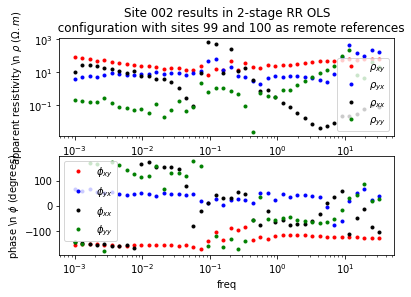

In [14]:
fig = plt.figure()
ax = plt.subplot(2, 1, 1)
plt.loglog(freq,1e12*np.abs(ImpOLS.impedance[:,0,1])**2/freq,'r.',label=r'$\rho_{xy}$')
plt.loglog(freq,1e12*np.abs(ImpOLS.impedance[:,1,0])**2/freq,'b.',label=r'$\rho_{yx}$')
plt.loglog(freq,1e12*np.abs(ImpOLS.impedance[:,0,0])**2/freq,'k.',label=r'$\rho_{xx}$')
plt.loglog(freq,1e12*np.abs(ImpOLS.impedance[:,1,1])**2/freq,'g.',label=r'$\rho_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity \n $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR OLS\n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
plt.semilogx(freq,np.angle(ImpOLS.impedance[:,0,1],deg=1),'r.',label=r'$\phi_{xy}$')
plt.semilogx(freq,np.angle(ImpOLS.impedance[:,1,0],deg=1),'b.',label=r'$\phi_{yx}$')
plt.semilogx(freq,np.angle(ImpOLS.impedance[:,0,0],deg=1),'k.',label=r'$\phi_{xx}$')
plt.semilogx(freq,np.angle(ImpOLS.impedance[:,1,1],deg=1),'g.',label=r'$\phi_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'phase \n $\phi$ (degrees)');
plt.legend()


### Now computing 2-stage M-Estimator Transfer Function for site002 with sites 100 and 99 as remote references 

In [15]:
from razorback.weights import bi_weights, mest_weights
from razorback.prefilters import bcoher_filter
from razorback.prefilters import bcoher_filter

sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpME = rb.utils.impedance(
    sig, freq,
     weights= mest_weights,#bi_weights(0.1, 3),  # bounded influence with reject probability of 10% and 3 steps
    remote='Bremote', # including the remotes references in the coputation,
    prefilter=bcoher_filter(0.0), # prefilter: bcoher_filter(0.0)
    fourier_opts=dict( Nper= 8,  overlap= 0.71) # fourier options with 8 periods by window, and 71% of overlap
)
print(ImpME.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (8, 6, 5, 7)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.0012879
starting frequency 0.00165868
starting frequency 0.00213622
starting frequency 0.00275123
starting frequency 0.0035433
starting frequency 0.00456342
starting frequency 0.00587722
starting frequency 0.00756926
starting frequency 0.00974845
starting frequency 0.012555
starting frequency 0.0161696
starting frequency 0.0208248
starting frequency 0.0268202
starting frequency 0.0345417
starting frequency 0.0444862
starting freque

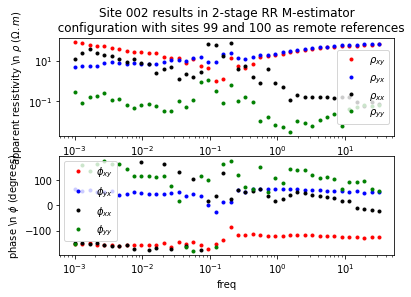

In [16]:
fig = plt.figure()
ax = plt.subplot(2, 1, 1)
plt.loglog(freq,1e12*np.abs(ImpME.impedance[:,0,1])**2/freq,'r.',label=r'$\rho_{xy}$')
plt.loglog(freq,1e12*np.abs(ImpME.impedance[:,1,0])**2/freq,'b.',label=r'$\rho_{yx}$')
plt.loglog(freq,1e12*np.abs(ImpME.impedance[:,0,0])**2/freq,'k.',label=r'$\rho_{xx}$')
plt.loglog(freq,1e12*np.abs(ImpME.impedance[:,1,1])**2/freq,'g.',label=r'$\rho_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity \n $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR M-estimator\n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
plt.semilogx(freq,np.angle(ImpME.impedance[:,0,1],deg=1),'r.',label=r'$\phi_{xy}$')
plt.semilogx(freq,np.angle(ImpME.impedance[:,1,0],deg=1),'b.',label=r'$\phi_{yx}$')
plt.semilogx(freq,np.angle(ImpME.impedance[:,0,0],deg=1),'k.',label=r'$\phi_{xx}$')
plt.semilogx(freq,np.angle(ImpME.impedance[:,1,1],deg=1),'g.',label=r'$\phi_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'phase \n $\phi$ (degrees)');
plt.legend()


### Now computing 2-stage Bounded Influence Transfer Function for site002 with sites 100 and 99 as remote references for a rejection percentage of 1% and 3 bounded influence steps

In [17]:
from razorback.weights import bi_weights, mest_weights
from razorback.prefilters import bcoher_filter
from razorback.prefilters import bcoher_filter

sig = prepare_signalset(inv, 'site004', ['site100', 'site099'])
print(sig)
ImpBI = rb.utils.impedance(
    sig, freq,
     weights= bi_weights(0.01, 3),  # bounded influence with reject probability of 1% and 3 steps
    remote='Bremote', # including the remotes references in the coputation,
    prefilter=bcoher_filter(0.0), # prefilter: bcoher_filter(0.0)
    fourier_opts=dict( Nper= 8,  overlap= 0.71) # fourier options with 8 periods by window, and 71% of overlap
)
print(ImpBI.impedance.shape)

SignalSet: 9 channels, 1 run
tags: {'site004_Ex': (0,), 'site004_Ey': (1,), 
       'site004_Hx': (2,), 'site004_Hy': (3,), 
       'site004_Hz': (4,), 'site099_Hx': (5,), 
       'site099_Hy': (6,), 'site100_Hx': (7,), 
       'site100_Hy': (8,), 'B': (2, 3), 
       'E': (0, 1), 'Bremote': (8, 6, 5, 7)}
----------  -------------------  -------------------
  sampling                start                 stop
       128  2016-04-28 19:00:00  2016-04-29 07:00:00
----------  -------------------  -------------------
starting frequency 0.001
starting frequency 0.0012879
starting frequency 0.00165868
failed to converge (maxit=100). while processing step 3 (weighting=1).
starting frequency 0.00213622
starting frequency 0.00275123
starting frequency 0.0035433
starting frequency 0.00456342
starting frequency 0.00587722
starting frequency 0.00756926
starting frequency 0.00974845
starting frequency 0.012555
starting frequency 0.0161696
starting frequency 0.0208248
starting frequency 0.0268202
st

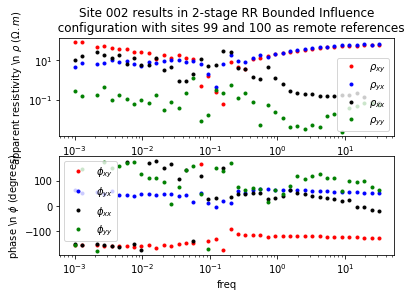

In [18]:
fig = plt.figure()
ax = plt.subplot(2, 1, 1)
plt.loglog(freq,1e12*np.abs(ImpBI.impedance[:,0,1])**2/freq,'r.',label=r'$\rho_{xy}$')
plt.loglog(freq,1e12*np.abs(ImpBI.impedance[:,1,0])**2/freq,'b.',label=r'$\rho_{yx}$')
plt.loglog(freq,1e12*np.abs(ImpBI.impedance[:,0,0])**2/freq,'k.',label=r'$\rho_{xx}$')
plt.loglog(freq,1e12*np.abs(ImpBI.impedance[:,1,1])**2/freq,'g.',label=r'$\rho_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'apparent resistivity \n $\rho$ ($\Omega.m$)');
plt.legend()

plt.title('Site 002 results in 2-stage RR Bounded Influence\n  configuration with sites 99 and 100 as remote references')
ax = plt.subplot(2, 1, 2)
plt.semilogx(freq,np.angle(ImpBI.impedance[:,0,1],deg=1),'r.',label=r'$\phi_{xy}$')
plt.semilogx(freq,np.angle(ImpBI.impedance[:,1,0],deg=1),'b.',label=r'$\phi_{yx}$')
plt.semilogx(freq,np.angle(ImpBI.impedance[:,0,0],deg=1),'k.',label=r'$\phi_{xx}$')
plt.semilogx(freq,np.angle(ImpBI.impedance[:,1,1],deg=1),'g.',label=r'$\phi_{yy}$')
plt.xlabel('freq')
plt.ylabel(r'phase \n $\phi$ (degrees)');
plt.legend()